
## **Quanvolutional Neural Networks**



In [2]:
pip install pennylane --upgrade

Requirement already up-to-date: pennylane in c:\users\mohamedyassineferjan\anaconda3\lib\site-packages (0.11.0)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pennylane-qiskit

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Setting of the main hyper-parameters of the model



In [5]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


## **Loading of the MNIST dataset!**



In [6]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]



## **Quanv Layer**

In [7]:
dev = qml.device("default.qubit", wires=4)

In [8]:
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))



@qml.qnode(dev)
def circuit(phi=None):
    # Encoding of 4 classical input values
   
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [9]:

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                phi=[image[j, k, 0], image[j, k + 1, 0], image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

**Quantum pre-processing**

In [10]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))#add the Qlayer
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


FileNotFoundError: [Errno 2] No such file or directory: 'quanvolution/q_train_images.npy'

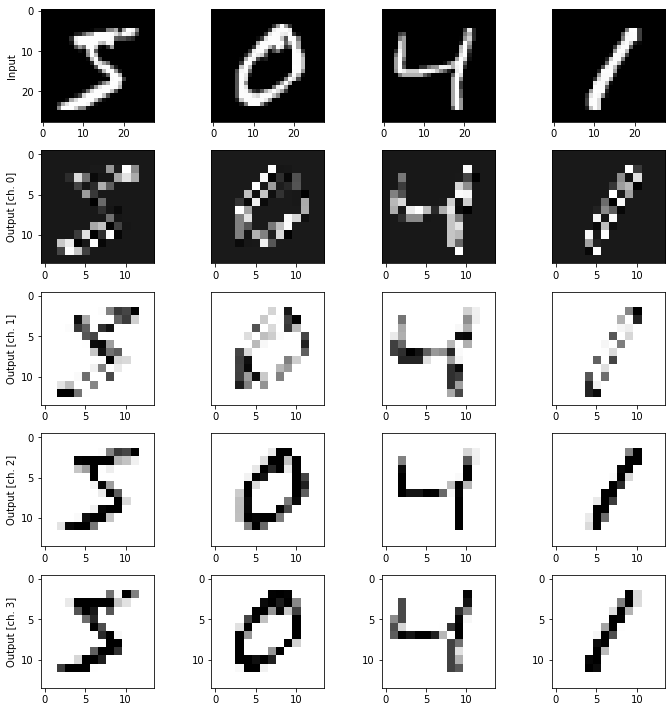

In [11]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


**Hybrid quantum-classical model**

In [12]:
def MyModel():
   
    
    model = keras.models.Sequential([
        
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)), 
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),                                                 
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    
    
    
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

**Training**

In [13]:

# Args:
# graph_or_graph_def: A Graph or a GraphDef protocol buffer.
# logdir: Directory where to write the graph. This can refer to remote filesystems, such as Google Cloud Storage (GCS).
# name: Filename for the graph.
# as_text: If True, writes the graph as an ASCII proto.tf.train.write_graph(session.graph_def, "./export", "network.pb", False)
#tf.train.write_graph(session.graph_def, "./export", "network.pb", False)
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Train on 50 samples, validate on 30 samples
Epoch 1/30
50/50 - 1s - loss: 2.3639 - accuracy: 0.1400 - val_loss: 2.2001 - val_accuracy: 0.2000
Epoch 2/30
50/50 - 0s - loss: 1.9019 - accuracy: 0.3600 - val_loss: 1.9828 - val_accuracy: 0.3667
Epoch 3/30
50/50 - 0s - loss: 1.6296 - accuracy: 0.6000 - val_loss: 1.7908 - val_accuracy: 0.5333
Epoch 4/30
50/50 - 0s - loss: 1.3372 - accuracy: 0.7600 - val_loss: 1.5639 - val_accuracy: 0.7667
Epoch 5/30
50/50 - 0s - loss: 1.0014 - accuracy: 0.9800 - val_loss: 1.3784 - val_accuracy: 0.7000
Epoch 6/30
50/50 - 0s - loss: 0.7677 - accuracy: 0.9000 - val_loss: 1.1909 - val_accuracy: 0.8000
Epoch 7/30
50/50 - 0s - loss: 0.5255 - accuracy: 1.0000 - val_loss: 1.0556 - val_accuracy: 0.8000
Epoch 8/30
50/50 - 0s - loss: 0.3531 - accuracy: 1.0000 - val_loss: 0.8825 - val_accuracy: 0.7667
Epoch 9/30
50/50 - 0s - loss: 0.2194 - accuracy: 1.0000 - val_loss: 0.8538 - val_accuracy: 0.8000
Epoch 10/30
50/50 - 0s - loss: 0.1663 - accuracy: 1.0000 - val_loss: 0.744

In [14]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Train on 50 samples, validate on 30 samples
Epoch 1/30
50/50 - 1s - loss: 2.2993 - accuracy: 0.1200 - val_loss: 2.2365 - val_accuracy: 0.2333
Epoch 2/30
50/50 - 0s - loss: 2.0305 - accuracy: 0.3400 - val_loss: 2.0273 - val_accuracy: 0.2667
Epoch 3/30
50/50 - 0s - loss: 1.6471 - accuracy: 0.5000 - val_loss: 1.4731 - val_accuracy: 0.6667
Epoch 4/30
50/50 - 0s - loss: 1.0101 - accuracy: 0.8600 - val_loss: 1.0462 - val_accuracy: 0.7667
Epoch 5/30
50/50 - 0s - loss: 0.4920 - accuracy: 0.9200 - val_loss: 0.8743 - val_accuracy: 0.7000
Epoch 6/30
50/50 - 0s - loss: 0.2594 - accuracy: 0.9000 - val_loss: 0.8922 - val_accuracy: 0.8000
Epoch 7/30
50/50 - 0s - loss: 0.1287 - accuracy: 1.0000 - val_loss: 0.9253 - val_accuracy: 0.7333
Epoch 8/30
50/50 - 0s - loss: 0.0927 - accuracy: 0.9800 - val_loss: 0.9214 - val_accuracy: 0.7667
Epoch 9/30
50/50 - 0s - loss: 0.0395 - accuracy: 1.0000 - val_loss: 0.8898 - val_accuracy: 0.7667
Epoch 10/30
50/50 - 0s - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.830

In [15]:
q_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2570      
Total params: 41,866
Trainable params: 41,866
Non-trainable params: 0
____________________________________________________

In [16]:
c_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  16010     
Total params: 53,578
Trainable params: 53,578
Non-trainable params: 0
__________________________________________________

In [17]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
q=c_model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images,test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.


Train on 50 samples, validate on 30 samples
Epoch 1/10
32/50 [==================>...........] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 00001: saving model to training_1/cp.ckpt
50/50 [==============================] - 1s 11ms/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0390 - val_accuracy: 0.7667
Epoch 2/10
32/50 [==================>...........] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 00002: saving model to training_1/cp.ckpt
50/50 [==============================] - 0s 7ms/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0411 - val_accuracy: 0.7667
Epoch 3/10
32/50 [==================>...........] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 00003: saving model to training_1/cp.ckpt
50/50 [==============================] - 0s 5ms/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0426 - val_accuracy: 0.7667
Epoch 4/10
32/50 [==================>...........] - ETA: 0s - loss: 9.8273e-04 - accuracy: 1.0000
Epoch 00004: saving model to training_

In [18]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
k=q_model.fit(q_train_images, 
          train_labels,  
          epochs=10,
          validation_data=(q_test_images,test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Train on 50 samples, validate on 30 samples
Epoch 1/10
32/50 [==================>...........] - ETA: 0s - loss: 0.0083 - accuracy: 1.0000
Epoch 00001: saving model to training_1/cp.ckpt
50/50 [==============================] - 0s 5ms/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4644 - val_accuracy: 0.8667
Epoch 2/10
32/50 [==================>...........] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000
Epoch 00002: saving model to training_1/cp.ckpt
50/50 [==============================] - 0s 4ms/sample - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.4646 - val_accuracy: 0.8667
Epoch 3/10
32/50 [==================>...........] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000
Epoch 00003: saving model to training_1/cp.ckpt
50/50 [==============================] - 0s 7ms/sample - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.4644 - val_accuracy: 0.8667
Epoch 4/10
32/50 [==================>...........] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000
Epoch 00004: saving model to training_1/cp.

In [19]:
import tensorflow as tf
import tensorflow as tf
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
sess = tf.Session()
saver = tf.train.Saver()

tf.io.write_graph(sess.graph, './graph', 'graph.pbtxt')
# session is run


ValueError: No variables to save

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.python.tools import freeze_graph

In [ ]:
# Freeze the graph
#save_path="Users\MohamedyassineFerjan\Desktop\mnist q\graph\graph.pbtxt" #directory to model files
save_path="Users\MohamedyassineFerjan\Desktop\mnist q"
MODEL_NAME = 'Sample_model'  #name of the model optional
input_graph_path = 'Users\MohamedyassineFerjan\Desktop\mnist q\graph\graph.pbtxt'#complete path to the input graph

checkpoint_path = save_path+'model.ckpt' #complete path to the model's checkpoint file
input_saver_def_path = ""
input_binary = False
output_node_names = "output" #output node's name. Should match to that mentioned in your code
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = save_path+'frozen_model_'+MODEL_NAME+'.pb' # the name of .pb file you would like to give
clear_devices = True

In [ ]:
freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_frozen_graph_name, clear_devices, "")

In [ ]:

import tensorflow.compat.v1 as tf
from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["Users\MohamedyassineFerjan\Downloads\graph\graph.pbtxt"])
graph_io.write_graph(frozen, './', 'inference_graph.pb', as_text=False)

In [ ]:

w=q_model.trainable_variables

In [ ]:
c_model.save('official')


In [20]:
q_model.save('term')



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


RuntimeError: Attempting to capture an EagerTensor without building a function.

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:

"""
tf.compat.v1.disable_eager_execution() # need to disable eager in TF2.x
# Build a graph.
a = tf.constant(5.0)
b = tf.constant(6.0)
c = a * b

# Launch the graph in a session.
sess = tf.compat.v1.Session()

# Evaluate the tensor `c`.
print(sess.run(c)) # prints 30.0
"""

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [ ]:
import tensorflow as tf
import tensorflow.compat.v1 as tf

from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, [n.name for n in tf.get_default_graph().as_graph_def().node])
graph_io.write_graph(frozen, './', 'inference_graph.pb', as_text=False)

In [ ]:
sess=tf.compat.v1.Session()


**References**


*   https://pennylane.ai/qml/demos/tutorial_quanvolution.html

*   
Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.





In [ ]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
sess=tf.compat.v1.Session()

from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, [n.name for n in tf.get_default_graph().as_graph_def().node])
graph_io.write_graph(frozen, './', 'inference_graph.pb', as_text=False)